<a href="https://colab.research.google.com/github/Demilaris/Control-prosthesis-s-knee-angle-/blob/main/Term_Project_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
import numpy as np
from scipy.integrate import odeint

In [158]:
ls = 0.421
lt = 0.419
rs = 0.182         
rt = 0.181
ms = 4.8
mt = 5.6
Is = 0.04
g = 9.81
params = {'ls':ls, 'lt':lt, 'rs':rs,
          'rt': rt, 'ms':ms, 'mt':mt, 
          'Is': Is, 'g':g}


In [159]:
def hip_traj(t, B, alpha): 
  
  phi = B *np.cos(alpha* t**2)
  dphi =  -2*alpha*B *t *np.sin(alpha *t**2)
  ddphi = -2 * alpha * B * (np.sin(alpha * t**2 ) + 2 * alpha * t**2 * np.cos(alpha* t**2))

  return phi,dphi,ddphi

def trajectory(phi,dphi,ddphi): 
  theta = 8.72 + (0.33 * phi) + (0.028 * phi**2) - (0.015 * phi**3) + \
      (0.002 * phi**4) - (4.8 * np.e**-5 * phi**5) - \
      (5.6 * np.e**-6 * phi**6) + (3.3 * np.e**-7 * phi**7) - (4.8 * np.e**-9 * phi**8) 

  dtheta = - 0.00473894*phi**7 + 0.0210645 *phi**6 - 0.0210645 *phi**5 - 0.0210645 *phi**4 + 0.008*phi**3 - 0.0045*phi**2 + 0.056*phi + 0.33
  ddtheta = -0.033*phi**6 - 0.0415*phi**4 - 0.069*phi**3 + 0.024*phi**2 - 0.009*phi + 0.056

  return theta, dtheta, ddtheta 

In [160]:
def control(x,phi,dphi,ddphi, controller_gains):
  theta, dtheta = x 
  kd, kp = controller_gains
  theta_d, dtheta_d,ddtheta_d = trajectory(phi,dphi,ddphi)

  u =  kd*(dtheta_d - dtheta) + kp * (theta_d - theta)

  return u 

In [161]:
def sysode(x,t,pars, traj_params, controller_gains): 
  theta, dtheta = x 
  ls = pars['ls']
  lt = pars['lt']
  rs = pars['rs']
  rt = pars['rt']
  ms = pars['ms']
  mt = pars['mt']
  Is = pars['Is']
  g  = pars['g']
  
  B,alpha = traj_params

  #I's 
  I_theta = Is + ms*rs**2
  I_phi = -1*(Is + (ms*rs**2) + (ms*lt*rs* np.cos(theta)))

  #get hip angle
  phi, dphi, ddphi = hip_traj(t,B,alpha) 
   
  #get knee angle
  theta_d, dtheta_d,ddtheta_d = trajectory(phi,dphi,ddphi)

  #calculate state terms
  V = ms*lt*rs* np.sin( theta) * dphi**2
  G = g*ms*rs* np.sin(theta-phi)
  
  #control
  v =  control(x, phi,dphi,ddphi,controller_gains)

  u = G + V - I_phi*ddphi + I_theta *theta_d + v

  #acceleration
  ddtheta = (1/I_theta) *  (I_phi*ddphi - V - G + u)

  dx = dtheta, ddtheta

  return dx


In [162]:
# Integration
t0 = 0 # Initial time 
tf = 10 # Final time
N = 2E3 # Numbers of points in time span
t = np.linspace(t0, tf, int(N)) # Create time span 


#trajectory parameters 
B = 1
alpha = 0.4
traj_params = B,alpha

controller_gains = 10,130
 
phi0,dphi0,ddphi0 = hip_traj(t0, B ,alpha)
initial_theta = trajectory(phi0,dphi0,ddphi0)
x0 = initial_theta[0],initial_theta[1]


sol = odeint(sysode, x0, t, args=(params, traj_params, controller_gains,)) # Integrate system
q, dq = sol[:,0], sol[:,1]
print(q)

[9.02119369 9.02311227 9.0251799  ... 8.74440855 8.73282886 8.72137257]


In [163]:
phi_array = []
theta_array=[]
for ti in t: 
  phi_i, dphi_i, ddphi_i =  hip_traj(ti, B, alpha)
  phi_array.append(phi_i)
  theta_i, dtheta_i,ddtheta_i = trajectory(phi_i, dphi_i, ddphi_i)
  theta_array.append(theta_i)

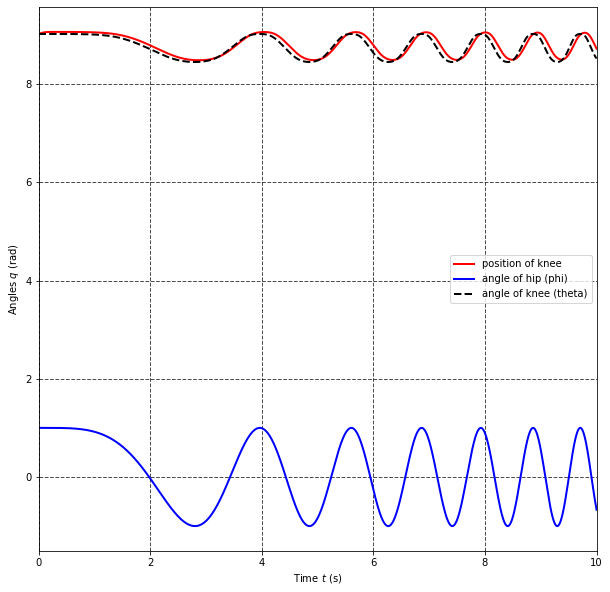

In [164]:
from matplotlib.pyplot import *
figure(figsize=(10,10))
plot(t, q,'r', linewidth=2.0, label = 'position of knee')
plot(t, phi_array,'b', linewidth=2.0, label = 'angle of hip (phi)')
plot(t, theta_array,'k', linestyle='--' , linewidth=2.0, label = 'angle of knee (theta)')
# hlines(trajectory_params['q_d'][0], t0, tf,color = 'black', linestyle = '--', alpha = 0.7)
# hlines(trajectory_params['q_d'][1], t0, tf,color = 'black', linestyle = '--', alpha = 0.7)
# plot(t, alpha_1_exct,'r--', linewidth=2.0, alpha = 0.6)
# plot(t, alpha_2_exct,'b--', linewidth=2.0, alpha = 0.6)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([0, tf])
legend()
ylabel(r'Angles $q$ (rad)')
xlabel(r'Time $t$ (s)')
show()